# **COMO CONSTRUIR UMA CNN COM PYTORCH**

Iremos aplicar ao dataset MNIST. Mas antes disso, iremos ver cada parte de módulos fundamentais do Pytorch que facilitam nossa vida.

- Iremos importar as funções
- Definir nosso transformador, que é a classe que realiza transformações nas imagens
- Carregar o dataset. 
- Inspecionar e visualizar o dataset
- criar um DataLoader para carregar batches de imagens
- Contruir o modelo
- Treinar o modelo 
- Analisar a acurácia
- Salvando o modelo
- Visualizar os logs de treino.


In [1]:
import torch

#nos usamos o torchvision para carregar o dataset e usar transformações nas imagens
import torchvision
import torchvision.transforms as transforms

#iremos também, importar os otimizadores para a rede e a rede em si.
import torch.nn as nn
import torch.optim as optim



In [2]:
#Verificar se temos GPU para rodar nossos experimentos.
print("GPU disponível: {}".format(torch.cuda.is_available()))

#Normalmente se define cuda ou cpu, para não ter problemas de compatibilidade com o pytorch
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

GPU disponível: True


### Transformadores

Os transformadores são necessários para converter os dados da imagem no formato necessário para a entrada em nosso modelo.

- Ele é composto usando a função ```transforms.Compose```
- Encadeamos os comandos ou instruções do nosso pipeline como argumentos
- Usamos ```transforms.ToTensor()``` para converter os dados da imagem em um Tensor PyTorch
- Usamos ```transforms.Normalize()``` para normalizar nossos valores de pixel
- Ao passar a entrada como ```(0.5, ), (0.5,)```, normalizamos nossos dados de imagem entre -1 e +1 
- Observação: para imagens RGB, usamos ```transformed.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))``` 


**NOTA**:
Nossos valores brutos de pixel em nosso conjunto de dados MNIST variam de 0 a 255. Cada imagem tem 28 pixels de altura e 28 pixels de largura, com uma profundidade de 1, pois é em escala de cinza.

**Por que normalizar?**

1. Para garantir que todos os recursos ou, no nosso caso, as intensidades dos pixels, sejam ponderados igualmente ao treinar a CNN
2. Torna o treinamento mais rápido, pois evita oscilações durante o treinamento
3. Remove o viés ou a distorção em nossos dados de imagem


**Por que 0,5?**

A normalização é feita da seguinte forma:

`image = (image - mean) / std`

Usar os parâmetros 0,5,0,5 define a média e o STD como 0,5. Usando a fórmula acima, obtemos o seguinte

- Valor mínimo = `(0-0,5)/0,5 = 1`
- Valor máximo = `(1-0,5)/0,5 = -1`

Para imagens coloridas, usamos uma tupla de (0.5,0.5,0.5) para definir a média dos canais RGB como 0.5 e outra tupla de (0.5, 0.5, 0.5) para definir o STD como 0.5

Já a transformação de ToTensor(), cria tensores.

Os tensores no PyTorch são estruturas de dados fundamentais usadas para representar e manipular dados multidimensionais, semelhantes a arrays do NumPy, mas com funcionalidades avançadas para computação numérica e aprendizado de máquina. Eles são a unidade básica de operação no PyTorch e permitem cálculos eficientes, inclusive em GPUs. Aqui estão os principais aspectos:

- Generalização de escalares, vetores e matrizes, Tensores podem ter N dimensões

- Atributos chave: shape, dtype, device.

- Computação Acelerada (GPU)

- Operações Numéricas
    - Aritmética: Adição (+), multiplicação (*), produto matricial (@ ou torch.matmul).

    - Redimensionamento: .view(), .reshape(), .transpose().

    - Funções matemáticas: torch.sin(), torch.exp(), torch.sum().

    - Indexação e slicing: Semelhante ao NumPy
- Integração com NumPy
- Tensores podem rastrear gradientes se requires_grad=True for definido, habilitando o cálculo automático de derivadas (útil para treinar redes neurais).

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
#Dessa forma, a gente normaliza os valores entre -1 e 1

### **Obtendo o conjunto de dados MNIST usando o torchvision**

**NOTA** 

- Muitos tutoriais on-line afirmam que as transformações são aplicadas no carregamento. Isso NÃO é verdade. Os transformadores são aplicados somente quando carregados pelo nosso Data Loader. 
- Nosso conjunto de dados permanece inalterado, apenas os lotes de imagens carregados pelo nosso Data Loader são copiados e transformados a cada iteração.
- Veja outros conjuntos de dados que podem ser acessados via torchvision aqui - https://pytorch.org/vision/stable/datasets.html


In [4]:
#Carregando o conjunto de treino e especificando qual transformador sera usado durante o carregamento. 

trainset = torchvision.datasets.MNIST('mnist', train = True, download= True, transform = transform)

#Carregando os dados de teste e especificando qual transformador sera usando durante o carregamento.

testset = torchvision.datasets.MNIST('mnist', train = False, download= True, transform = transform)

### Sobre os dados de treinamento e teste

Há dois subconjuntos de dados que estão sendo usados aqui:

- Dados de treinamento** Dados que são usados para otimizar os parâmetros do modelo (usados durante o treinamento)
- Dados de teste/validação** Dados que são usados para avaliar o desempenho do modelo 

Durante o treinamento, monitoramos o desempenho do modelo nos dados de teste.

**Boa prática de aprendizado de máquina**

Geralmente, mantemos outro **conjunto de testes** para testar o modelo final a fim de obter uma estimativa imparcial da precisão *fora da amostra*. 

No entanto, o MNIST não tem um conjunto de teste separado. Portanto, usamos o conjunto de teste para validação e teste. 


In [5]:
# Temos 60.000 amostras de imagem para nossos dados de treinamento e 10.000 para nossos dados de teste
# Cada uma tem 28 x 28 pixels e, como são em escala de cinza, não há uma terceira dimensão em nossa imagem

print(trainset.data.shape)
print(testset.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


#### **Vamos dar uma olhada em uma amostra individual de dados**

Você verá que nossos dados ainda não foram normalizados entre -1 e 1.

In [6]:
print(trainset.data[0].shape)
print(trainset.data[0])

torch.Size([28, 28])
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,  

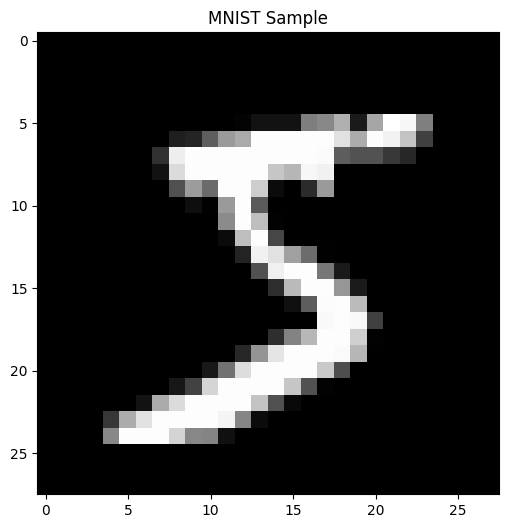

In [7]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Define uma funcao para mostrar imagens
def imgshow(title="", image = None, size = 6):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

# Converter uma imagem para numpy
image = trainset.data[0].numpy()
imgshow("MNIST Sample", image)

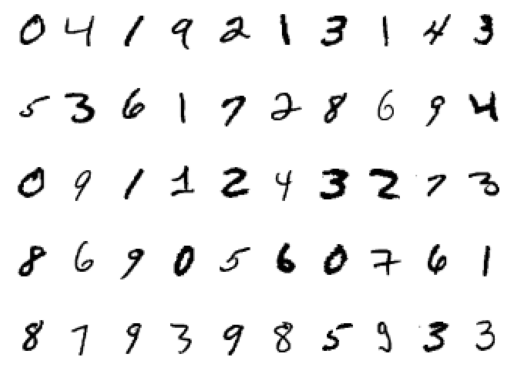

In [8]:
import matplotlib.pyplot as plt

figure = plt.figure()
num_of_images = 50 

for index in range(1, num_of_images + 1):
    plt.subplot(5, 10, index)
    plt.axis('off')
    plt.imshow(trainset.data[index], cmap='gray_r')

### CRIANDO UM DATALOADER

Um **Data Loader** é uma função que usaremos para obter nossos dados em tamanhos de lote especificados (usaremos 128) durante o treinamento. 

Lembre-se de que não podemos alimentar a rede com todos os dados de uma só vez, portanto, é por isso que dividimos os dados em lotes. 

Definimos **shuffle** igual a True para evitar a distorção da sequência de dados. Por exemplo, em alguns conjuntos de dados, cada classe geralmente está em ordem, portanto, para evitar o carregamento de lotes de apenas uma única classe, embaralhamos nossos dados.

O ``num_workers`` especifica quantos núcleos de CPU desejamos utilizar; defini-lo como 0 significa que será o processo principal que fará o carregamento de dados quando necessário. Deixe-o como 0, a menos que deseje fazer mais experimentos.



In [9]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=0)

testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=0)

In [10]:
#Para podermos manipular mais facilmente, iremos transformar nosso dataloader de treino em um iterator
dataiter = iter(trainloader)

#nos usamos a função next, para pegar o primeiro batch dos dados em nosso iterator
images, labels = dataiter._next_data()

print(images.shape)
print(labels.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


In [11]:
images[0].shape

torch.Size([1, 28, 28])

### O Pytorch também possui funções de visualização das imagens

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


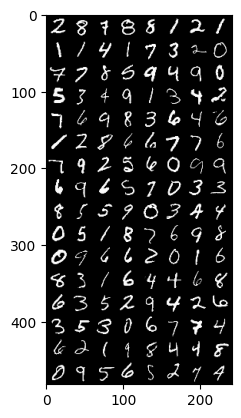

2 8 7 8 8 1 2 1 1 1 4 1 7 3 2 0 7 7 8 5 9 4 9 0 5 3 4 9 1 3 4 2 7 6 9 8 3 6 4 6 1 2 8 6 6 7 7 6 7 9 2 5 6 0 9 9 6 9 6 5 7 0 3 3 8 5 5 9 0 3 4 4 0 5 1 8 7 6 9 8 0 9 6 6 2 0 1 6 8 3 1 6 4 4 6 8 6 3 5 2 9 4 2 6 3 5 3 0 6 7 7 4 6 2 1 9 8 4 4 8 0 9 5 6 5 2 7 4


In [12]:
import matplotlib.pyplot as plt
import numpy

def imshow(image):
    img = image / 2 + 0.5
    npimg = image.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()


#pegar algumas imagens

dataiter = iter(trainloader)
images, labels = dataiter._next_data()

imshow(torchvision.utils.make_grid(images))
print(" ".join('%1s' % labels[j].numpy() for j in range(128)))

# CONTRUINDO O MODELO

Usaremos o método ```nn.Sequential`` para construir nosso modelo. Como alternativa, podemos usar o módulo funcional, mas ele é mais simples e mais semelhante aos estilos com os quais você trabalhará no Keras.

### Construindo uma camada de filtro de convolução**

```
nn.Conv2d(in_channels=1,
          out_channels=32,
          kernel_size=3,
          stride=1, 
          padding=1)
```

- **in_channels (int)** - Esse é o número de canais na imagem de entrada (para imagens em escala de cinza, use 1 e para imagens coloridas RGB, use 3)
- **out_channels (int)** - Esse é o número de canais produzidos pela convolução. Usamos 32 canais ou 32 filtros. **NOTA** 32 será o número de **in_channels** na próxima camada da rede.
- **kernel_size (int ou tuple)** - Este é o tamanho do kernel de convolução. Usamos 3 aqui, o que dá um tamanho de kernel de 3 x 3.
- stride (int ou tupla, opcional)** - Stride da convolução. (Padrão: 1)
- **padding (int ou tupla, opcional)** - Preenchimento zero adicionado a ambos os lados da entrada (Padrão: 0). Usamos um padding = 1.

### **Camada de Max Pool**

- Cada camada de pooling, ou seja, nn.MaxPool2d(2, 2), reduz pela metade a altura e a largura da imagem, portanto, ao usar 2 camadas de pooling, a altura e a largura são 1/4 dos tamanhos originais.

**O que é torch.nn.functional?**

Geralmente importado para o namespace F por convenção, esse módulo contém todas as funções da biblioteca torch.nn (enquanto outras partes da biblioteca contêm classes). Além de uma ampla gama de funções de perda e ativação, você também encontrará aqui algumas funções convenientes para a criação de redes neurais, como funções de pooling. (Há também funções para fazer convoluções, camadas lineares, etc., mas, como veremos, essas funções geralmente são mais bem tratadas em outras partes da biblioteca).

In [13]:
import torch.nn as nn
import torch.nn.functional as F

#Modelo é criado usando uma classe

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        #Definindo objetos de camadas.
        #Primeira camada com 32 kernels de 3x3 de tamanho, com stride 1 e padding 0.
        self.conv1 = nn.Conv2d(1,32,3,1,0)
        #A segunda camada com 64 filtros de 3x3 de tamanho, com stride 1 e padding 0.
        self.conv2 = nn.Conv2d(32,64,3,1,0)
        #Camada de max pooling 2x2, kernel com stride 2
        self.pool = nn.MaxPool2d(2, 2)
        #Nossa camada totalmente conectada, recebe a saída do max pooling que é 12x12x64 e conecta com 128 nós
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        #Nossa segunda camada totalmente conectada, conecta  os 128 nós de entrada da rede aos 10 nós de saída (as 10 classes do conjunto)
        self.fc2 = nn.Linear(128,10)

    
    def forward(self, x):
        #Aqui nós definimos a sequencia de propagação
        #lembre-se conv1 - relu - conv2 - relu - max pool - flatten - FC1 - FC2
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 12 * 12) #flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
#Criamos uma instancia do modelo e movemos ele para a GPU para realizar as operações
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### Definindo a nossa função de perda e otimizador.

Precisamos definir o tipo de perda que usaremos e o método que usaremos para atualizar os gradientes.
1. Usamos a perda de entropia cruzada por se tratar de um problema de várias classes
2. Usamos o Stochastic Gradient Descent (SGD) - também especificamos uma taxa de aprendizado (LR) de 0,001 e momentum de 0,9

In [14]:
#Importamos a função de otimização

#Usamos  a entropia cruzada como função de perda
criterio = nn.CrossEntropyLoss()

#Para o algoritmo da descida do gradiente usaremos a variação SGD com taxa de aprendizado de 0.001
#Iremos setar o momentum em 0.9
otimizador = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Treinando nosso modelo

No PyTorch, usamos as funções de bloco de construção para executar o algoritmo de treinamento com o qual já devemos estar familiarizados.

![](https://github.com/rajeevratan84/ModernComputerVision/raw/main/CleanShot%202020-11-29%20at%207.04.32%402x.png)

In [15]:
#Fazemos um loop sobre o conjunto de dados de treinamento várias vezes (cada vez é chamada de época)

epochs = 10

## Criar algumas matrizes vazias para armazenar os registros 

epoch_log = []
loss_log = []
accuracy_log = []

for epoch in range(epochs):  
    print(f'Iniciando epoca: {epoch+1}...')

    # nos mantemos adicionando ou acumulando nossa perda após cada mini-batch in running_loss
    running_loss = 0.0

    #Nós iteramos em nosso iterador de treino
    # Cada ciclo é um minilote

    for i, data in enumerate(trainloader, 0):
        # pegando a entrada, data é uma lista de [inputs, labels]
        inputs, labels = data

        # Move os dados para a GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        #Limpar os gradientes antes de treinar, pela configuração do zero
        #Necessario para um novo começo
        otimizador.zero_grad()

        #Forward -> backpropagation -> otimizador
        outputs = net(inputs) #Forward propagation
        loss = criterio(outputs, labels) #Pega a perda (quantifica a diferença entre os resultados e predições)
        loss.backward() #back propagate para obter o novo gradiente para todos os nós
        otimizador.step() #Atualiza os pesos

        # Print training statistics - ÉPOCA/ITERAÇÕES/LOSS/ACURÁCIA
        running_loss += loss.item()

        if i % 50 == 49: #mostra o loss a cada 50 mini-batches
            correct = 0 #Inicializa nossa variável para manter a contagem das previsões corretas 
            total = 0 #Inicialize nossa variável para manter a contagem do número de rótulos iterados

            # Não precisamos de gradientes para a validação, portanto, envolva 
            # no_grad para economizar memória

            with torch.no_grad():
                #Itera atraves do loader de test
                for data in testloader:
                    images, labels = data
                    images = images.to(device)
                    labels = labels.to(device)

                    # Foward propagete nos dados de test batch
                    outputs = net(images)

                    #Obter previsões a partir do valor máximo do tensor de saída previsto
                    #definimos dim = 1, pois ele especifica o número de dimensões a serem reduzidas
                    _, predicted = torch.max(outputs.data, dim=1)
                    
                    #Continue adicionando o tamanho ou o comprimento do rotulo à variável total
                    total += labels.size(0)

                    # Mantenha um total em execução do número de previsões feitas corretamente
                    correct += (predicted == labels).sum().item()
                
                accuracy = 100 * correct / total
                epoch_num = epoch + 1
                actual_loss = running_loss / 50
                print(f'Época: {epoch_num}, Mini-Batches Completados: {(i+1)}, Loss: {actual_loss:.3f}, Test Accuracy = {accuracy:.3f}%')
                running_loss = 0.0

    # Guarda os status do treino aós cada epoca
    epoch_log.append(epoch_num)
    loss_log.append(actual_loss)
    accuracy_log.append(accuracy)

print("Treino finalizado")

Iniciando epoca: 1...
Época: 1, Mini-Batches Completados: 50, Loss: 2.255, Test Accuracy = 54.170%
Época: 1, Mini-Batches Completados: 100, Loss: 2.029, Test Accuracy = 70.600%
Época: 1, Mini-Batches Completados: 150, Loss: 1.392, Test Accuracy = 81.160%
Época: 1, Mini-Batches Completados: 200, Loss: 0.713, Test Accuracy = 87.220%
Época: 1, Mini-Batches Completados: 250, Loss: 0.484, Test Accuracy = 88.090%
Época: 1, Mini-Batches Completados: 300, Loss: 0.423, Test Accuracy = 89.280%
Época: 1, Mini-Batches Completados: 350, Loss: 0.374, Test Accuracy = 90.310%
Época: 1, Mini-Batches Completados: 400, Loss: 0.367, Test Accuracy = 90.710%
Época: 1, Mini-Batches Completados: 450, Loss: 0.319, Test Accuracy = 91.150%
Iniciando epoca: 2...
Época: 2, Mini-Batches Completados: 50, Loss: 0.305, Test Accuracy = 91.770%
Época: 2, Mini-Batches Completados: 100, Loss: 0.290, Test Accuracy = 92.330%
Época: 2, Mini-Batches Completados: 150, Loss: 0.297, Test Accuracy = 91.750%
Época: 2, Mini-Batches

## Salvando o nosso modelo

Usamos a função torch.save()

net.state_dict() salva os pesos do modelo em um formato de dicionário

In [16]:
PATH = './mnist_cnn_net.pth'
torch.save(net.state_dict(), PATH)

## Vendo algumas imagens dos dados de teste e ver os rótulos verdadeiros

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


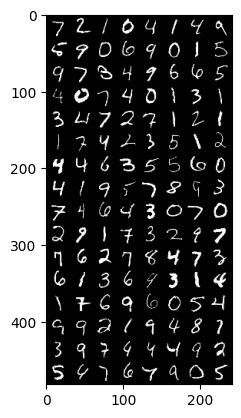

GroundTruth: 
 Imagem (0) - Valor verdadeiro:  7 
Imagem (1) - Valor verdadeiro:  2 
Imagem (2) - Valor verdadeiro:  1 
Imagem (3) - Valor verdadeiro:  0 
Imagem (4) - Valor verdadeiro:  4 
Imagem (5) - Valor verdadeiro:  1 
Imagem (6) - Valor verdadeiro:  4 
Imagem (7) - Valor verdadeiro:  9 
Imagem (8) - Valor verdadeiro:  5 
Imagem (9) - Valor verdadeiro:  9 
Imagem (10) - Valor verdadeiro:  0 
Imagem (11) - Valor verdadeiro:  6 
Imagem (12) - Valor verdadeiro:  9 
Imagem (13) - Valor verdadeiro:  0 
Imagem (14) - Valor verdadeiro:  1 
Imagem (15) - Valor verdadeiro:  5 
Imagem (16) - Valor verdadeiro:  9 
Imagem (17) - Valor verdadeiro:  7 
Imagem (18) - Valor verdadeiro:  3 
Imagem (19) - Valor verdadeiro:  4 
Imagem (20) - Valor verdadeiro:  9 
Imagem (21) - Valor verdadeiro:  6 
Imagem (22) - Valor verdadeiro:  6 
Imagem (23) - Valor verdadeiro:  5 
Imagem (24) - Valor verdadeiro:  4 
Imagem (25) - Valor verdadeiro:  0 
Imagem (26) - Valor verdadeiro:  7 
Imagem (27) - Valor ver

In [17]:
# Vendo um pequeno lote
dataiter = iter(testloader)
images, labels = next(dataiter)

# Mostrar as imagens usando torchvision's utils.make_grid()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: \n',''.join(f'Imagem ({j}) - Valor verdadeiro:  %1s \n' % labels[j].numpy() for j in range(128)))

## Carregando o modelo treinado

In [18]:
net = Net()
net.to(device)

# Load weights from the specified path
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## Fazendo previsões

Observe que, ao trabalhar com tensores na GPU, temos que convertê-los novamente em uma matriz numérica para realizar operações python neles.

In [19]:
## Vamos propagar um minilote e obter os resultados previstos
# Usamos a função Python iter para retornar um iterador para nosso objeto test_loader

test_iter = iter(testloader)

# Usamos next para obter o primeiro lote de dados do nosso iterador
images, labels = next(test_iter)

images = images.to(device)
labels = labels.to(device)

outputs = net(images)

_, predicted = torch.max(outputs, 1)

# Print our 128 predictions
print('Predicted: \n', ''.join(f'Imagem ({j}) - Resultado:  %1s \n' % predicted[j].cpu().numpy() for j in range(128)))

Predicted: 
 Imagem (0) - Resultado:  7 
Imagem (1) - Resultado:  2 
Imagem (2) - Resultado:  1 
Imagem (3) - Resultado:  0 
Imagem (4) - Resultado:  4 
Imagem (5) - Resultado:  1 
Imagem (6) - Resultado:  4 
Imagem (7) - Resultado:  9 
Imagem (8) - Resultado:  5 
Imagem (9) - Resultado:  9 
Imagem (10) - Resultado:  0 
Imagem (11) - Resultado:  6 
Imagem (12) - Resultado:  9 
Imagem (13) - Resultado:  0 
Imagem (14) - Resultado:  1 
Imagem (15) - Resultado:  5 
Imagem (16) - Resultado:  9 
Imagem (17) - Resultado:  7 
Imagem (18) - Resultado:  3 
Imagem (19) - Resultado:  4 
Imagem (20) - Resultado:  9 
Imagem (21) - Resultado:  6 
Imagem (22) - Resultado:  6 
Imagem (23) - Resultado:  5 
Imagem (24) - Resultado:  4 
Imagem (25) - Resultado:  0 
Imagem (26) - Resultado:  7 
Imagem (27) - Resultado:  4 
Imagem (28) - Resultado:  0 
Imagem (29) - Resultado:  1 
Imagem (30) - Resultado:  3 
Imagem (31) - Resultado:  1 
Imagem (32) - Resultado:  3 
Imagem (33) - Resultado:  4 
Imagem (34)

In [20]:
correct = 0 
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Acurácia da rede sobre 1000 imagens foi: {accuracy:.3}%')

Acurácia da rede sobre 1000 imagens foi: 98.1%


## Mostrando logs de Treino

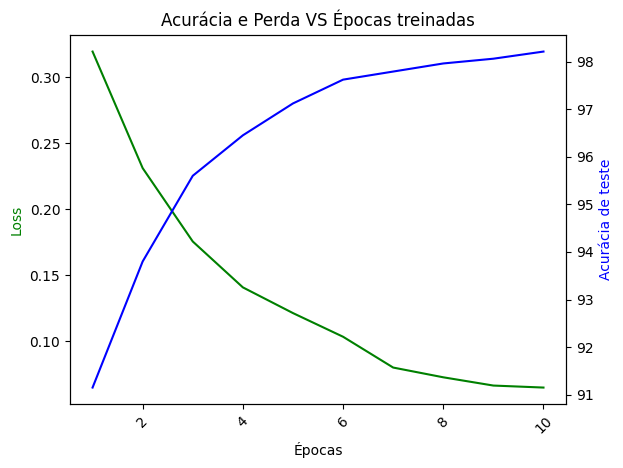

In [21]:
# Para criar um plot com o eixo y secundário nos precisamos de um subplot

fig, ax1 = plt.subplots()

#Setar o titulo e eixo x 
plt.title("Acurácia e Perda VS Épocas treinadas")
plt.xticks(rotation=45)

#Nós usamos twinx para criar um plot em cima de outro

ax2 = ax1.twinx()

#Criar o plot para perda e acurácia

ax1.plot(epoch_log, loss_log, 'g-')
ax2.plot(epoch_log, accuracy_log, 'b-')

#Setando os rótulos

ax1.set_xlabel("Épocas")
ax1.set_ylabel("Loss", color='g')
ax2.set_ylabel("Acurácia de teste", color='b')

plt.show()

In [ ]:
epoch_log = list(range(1,11)) #tem que ser 11 por que o numero de epocas vai até 10 e o 11 não é incluso
epoch_log

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

**Observações**

1. Se você tentar executar essa mesma rede na CPU (altere ```device = 'cpu'```). Você não perceberá uma grande diferença na velocidade. Isso ocorre porque sua rede é realmente pequena e há muita sobrecarga na simples movimentação dos dados. Em redes maiores ou mais profundas, o aumento da velocidade da GPU será substancial.

## PEGANDO A ACURÁCIA POR CLASSE

In [23]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

#Novamente, não queremos os gradientes para validação, usaremos o contexto no_grad

with torch.no_grad():
    for data in testloader:

        images, labels = data

        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)

        # use torch.max() para obter a classe prevista para a primeira dimensão do nosso lote
        # Observe que esses são apenas os primeiros 16 pontos de dados/imagens do nosso lote de 128 imagens 

        _, predicted = torch.max(outputs, 1)

        c = (predicted == labels).squeeze()

        for i in range(15):
            label = labels[i]

            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):

    class_accuracy = 100 * class_correct[i] / class_total[i]

    print(f'Acurácia de {i} : {class_accuracy:.3f}%')
    



Acurácia de 0 : 100.000%
Acurácia de 1 : 97.744%
Acurácia de 2 : 97.656%
Acurácia de 3 : 98.333%
Acurácia de 4 : 98.425%
Acurácia de 5 : 99.074%
Acurácia de 6 : 98.148%
Acurácia de 7 : 95.122%
Acurácia de 8 : 99.000%
Acurácia de 9 : 94.309%


In [24]:
c

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True], device='cuda:0')

**NOTA**

O ```net.eval()``` é uma espécie de interruptor para algumas camadas/partes específicas do modelo que se comportam de forma diferente durante o treinamento e o tempo de inferência (avaliação). Por exemplo, Dropouts Layers, BatchNorm Layers etc. Você precisa desativá-los durante a avaliação do modelo, e .eval() fará isso para você. Além disso, a prática comum para avaliação/validação é usar torch.no_grad() em conjunto com model.eval() para desativar o cálculo de gradientes:

## FILTRANDO PELAS PREDIÇÕES ERRADAS

torch.Size([128, 1, 28, 28])
Label predito: 4 | Label real: 9


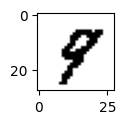

torch.Size([128, 1, 28, 28])
Label predito: 2 | Label real: 4


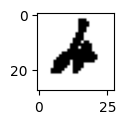

torch.Size([128, 1, 28, 28])
Label predito: 0 | Label real: 6


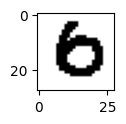

Label predito: 7 | Label real: 2


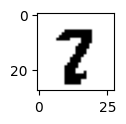

Label predito: 3 | Label real: 5


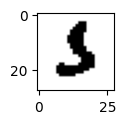

torch.Size([128, 1, 28, 28])
Label predito: 0 | Label real: 6


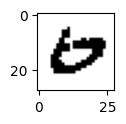

Label predito: 5 | Label real: 3


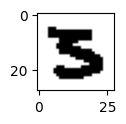

torch.Size([128, 1, 28, 28])
Label predito: 2 | Label real: 8


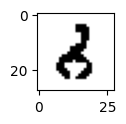

Label predito: 2 | Label real: 8


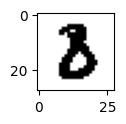

Label predito: 8 | Label real: 1


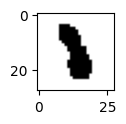

torch.Size([128, 1, 28, 28])
Label predito: 1 | Label real: 2


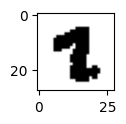

Label predito: 3 | Label real: 7


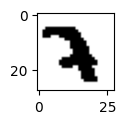

Label predito: 6 | Label real: 0


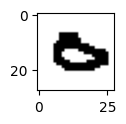

Label predito: 8 | Label real: 5


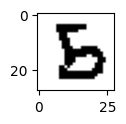

Label predito: 9 | Label real: 4


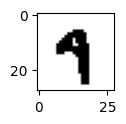

torch.Size([128, 1, 28, 28])
Label predito: 7 | Label real: 8


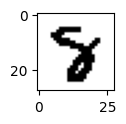

Label predito: 9 | Label real: 7


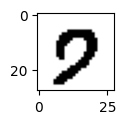

Label predito: 7 | Label real: 9


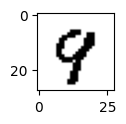

Label predito: 5 | Label real: 3


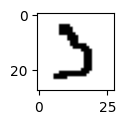

torch.Size([128, 1, 28, 28])
Label predito: 9 | Label real: 8


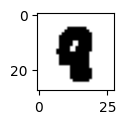

Label predito: 2 | Label real: 1


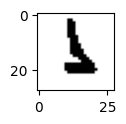

Label predito: 0 | Label real: 6


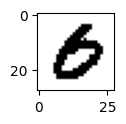

Label predito: 5 | Label real: 6


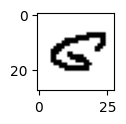

torch.Size([128, 1, 28, 28])
Label predito: 2 | Label real: 7


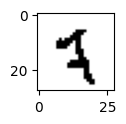

Label predito: 8 | Label real: 6


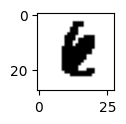

Label predito: 4 | Label real: 8


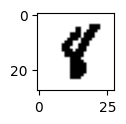

torch.Size([128, 1, 28, 28])
Label predito: 8 | Label real: 7


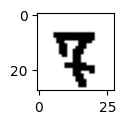

Label predito: 8 | Label real: 6


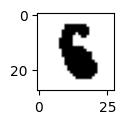

Label predito: 2 | Label real: 7


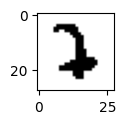

Label predito: 4 | Label real: 9


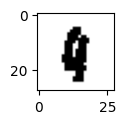

Label predito: 5 | Label real: 9


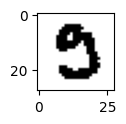

Label predito: 1 | Label real: 7


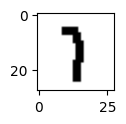

torch.Size([128, 1, 28, 28])
Label predito: 7 | Label real: 5


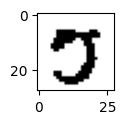

Label predito: 0 | Label real: 8


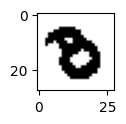

Label predito: 2 | Label real: 7


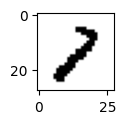

Label predito: 2 | Label real: 8


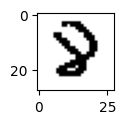

Label predito: 3 | Label real: 5


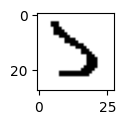

torch.Size([128, 1, 28, 28])
Label predito: 4 | Label real: 9


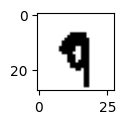

Label predito: 1 | Label real: 7


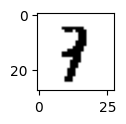

Label predito: 9 | Label real: 7


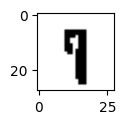

Label predito: 6 | Label real: 1


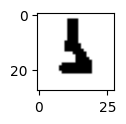

Label predito: 7 | Label real: 8


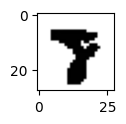

torch.Size([128, 1, 28, 28])
Label predito: 3 | Label real: 9


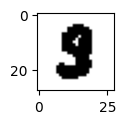

Label predito: 4 | Label real: 6


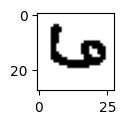

Label predito: 6 | Label real: 0


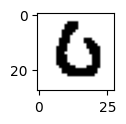

torch.Size([128, 1, 28, 28])
Label predito: 0 | Label real: 2


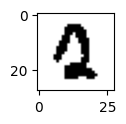

Label predito: 7 | Label real: 3


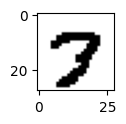

Label predito: 5 | Label real: 9


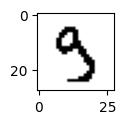

Label predito: 0 | Label real: 8


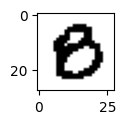

Label predito: 2 | Label real: 7


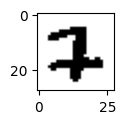

Label predito: 6 | Label real: 1


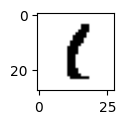

Label predito: 8 | Label real: 2


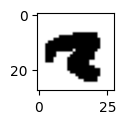

torch.Size([128, 1, 28, 28])
Label predito: 3 | Label real: 8


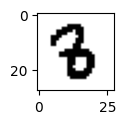

Label predito: 4 | Label real: 9


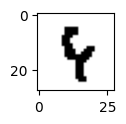

torch.Size([128, 1, 28, 28])
Label predito: 2 | Label real: 7


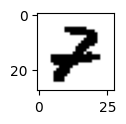

Label predito: 7 | Label real: 1


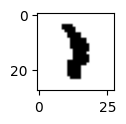

Label predito: 9 | Label real: 7


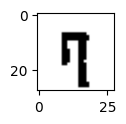

Label predito: 3 | Label real: 5


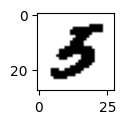

Label predito: 8 | Label real: 4


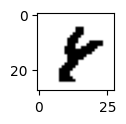

torch.Size([128, 1, 28, 28])
Label predito: 4 | Label real: 7


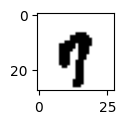

Label predito: 0 | Label real: 2


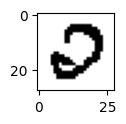

Label predito: 0 | Label real: 6


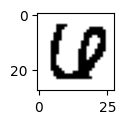

Label predito: 2 | Label real: 9


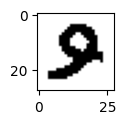

Label predito: 9 | Label real: 4


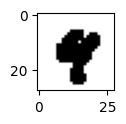

Label predito: 1 | Label real: 6


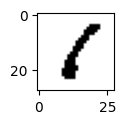

torch.Size([128, 1, 28, 28])
Label predito: 2 | Label real: 1


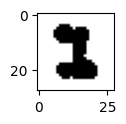

Label predito: 1 | Label real: 9


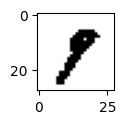

Label predito: 2 | Label real: 1


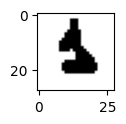

Label predito: 0 | Label real: 8


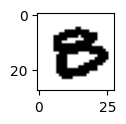

Label predito: 5 | Label real: 3


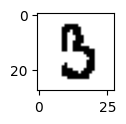

Label predito: 6 | Label real: 9


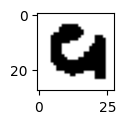

torch.Size([128, 1, 28, 28])
Label predito: 1 | Label real: 9


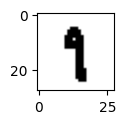

Label predito: 1 | Label real: 9


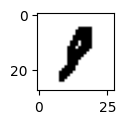

Label predito: 4 | Label real: 9


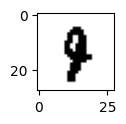

torch.Size([128, 1, 28, 28])
Label predito: 8 | Label real: 6


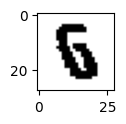

Label predito: 4 | Label real: 2


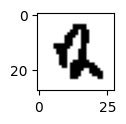

torch.Size([128, 1, 28, 28])
Label predito: 2 | Label real: 7


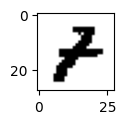

Label predito: 1 | Label real: 6


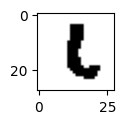

torch.Size([128, 1, 28, 28])
Label predito: 4 | Label real: 9


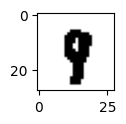

Label predito: 4 | Label real: 9


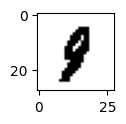

Label predito: 3 | Label real: 2


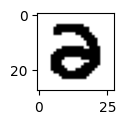

torch.Size([128, 1, 28, 28])
Label predito: 0 | Label real: 8


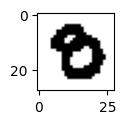

Label predito: 2 | Label real: 3


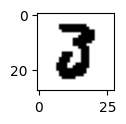

Label predito: 7 | Label real: 9


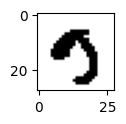

torch.Size([128, 1, 28, 28])
Label predito: 5 | Label real: 3


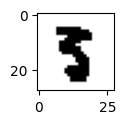

Label predito: 7 | Label real: 9


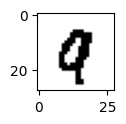

Label predito: 8 | Label real: 6


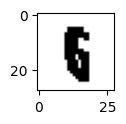

Label predito: 7 | Label real: 9


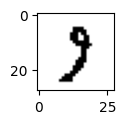

torch.Size([128, 1, 28, 28])
Label predito: 2 | Label real: 1


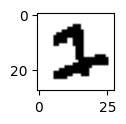

torch.Size([128, 1, 28, 28])
Label predito: 3 | Label real: 8


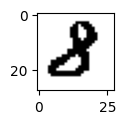

Label predito: 4 | Label real: 7


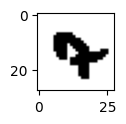

torch.Size([128, 1, 28, 28])
Label predito: 0 | Label real: 6


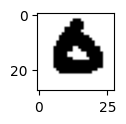

torch.Size([128, 1, 28, 28])
Label predito: 1 | Label real: 9


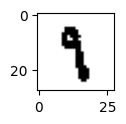

Label predito: 4 | Label real: 6


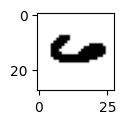

Label predito: 0 | Label real: 5


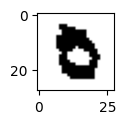

torch.Size([128, 1, 28, 28])
Label predito: 3 | Label real: 9


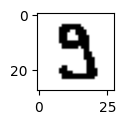

Label predito: 0 | Label real: 7


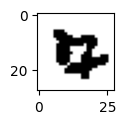

torch.Size([128, 1, 28, 28])
Label predito: 9 | Label real: 4


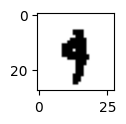

Label predito: 2 | Label real: 7


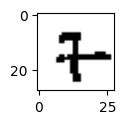

Label predito: 3 | Label real: 8


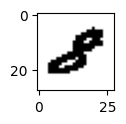

Label predito: 2 | Label real: 7


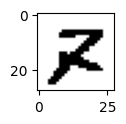

Label predito: 2 | Label real: 4


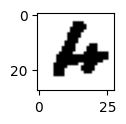

Label predito: 8 | Label real: 7


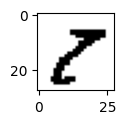

Label predito: 8 | Label real: 7


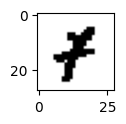

torch.Size([128, 1, 28, 28])
Label predito: 4 | Label real: 9


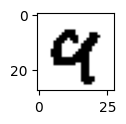

Label predito: 2 | Label real: 6


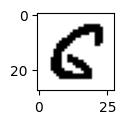

Label predito: 4 | Label real: 9


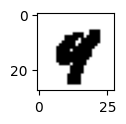

Label predito: 3 | Label real: 1


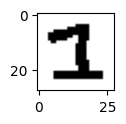

Label predito: 2 | Label real: 4


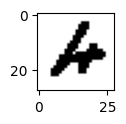

torch.Size([128, 1, 28, 28])
Label predito: 1 | Label real: 7


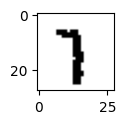

Label predito: 9 | Label real: 7


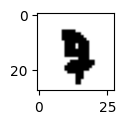

Label predito: 2 | Label real: 0


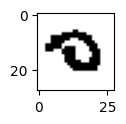

Label predito: 0 | Label real: 8


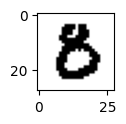

Label predito: 7 | Label real: 9


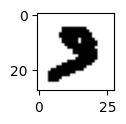

torch.Size([128, 1, 28, 28])
Label predito: 9 | Label real: 7


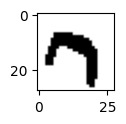

Label predito: 0 | Label real: 9


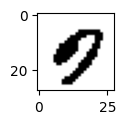

Label predito: 7 | Label real: 2


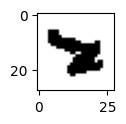

Label predito: 6 | Label real: 2


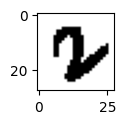

torch.Size([128, 1, 28, 28])
Label predito: 7 | Label real: 9


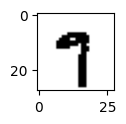

Label predito: 3 | Label real: 7


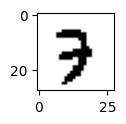

Label predito: 4 | Label real: 2


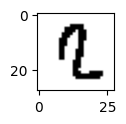

Label predito: 2 | Label real: 3


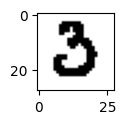

Label predito: 7 | Label real: 2


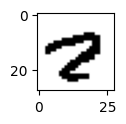

torch.Size([128, 1, 28, 28])
Label predito: 4 | Label real: 9


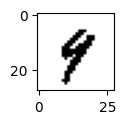

Label predito: 1 | Label real: 7


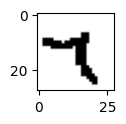

torch.Size([128, 1, 28, 28])
Label predito: 1 | Label real: 9


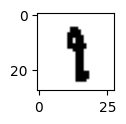

Label predito: 5 | Label real: 6


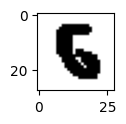

Label predito: 8 | Label real: 6


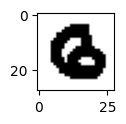

torch.Size([128, 1, 28, 28])
Label predito: 4 | Label real: 2


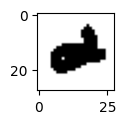

Label predito: 9 | Label real: 8


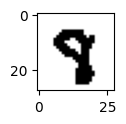

torch.Size([128, 1, 28, 28])
Label predito: 5 | Label real: 3


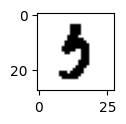

Label predito: 8 | Label real: 9


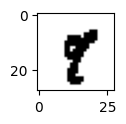

Label predito: 0 | Label real: 8


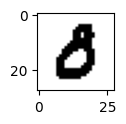

Label predito: 0 | Label real: 6


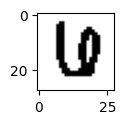

Label predito: 4 | Label real: 9


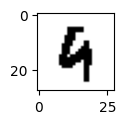

torch.Size([128, 1, 28, 28])
Label predito: 8 | Label real: 0


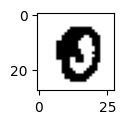

Label predito: 4 | Label real: 8


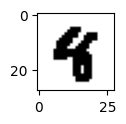

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
Label predito: 6 | Label real: 1


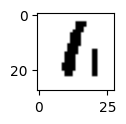

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
Label predito: 4 | Label real: 7


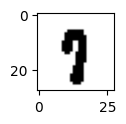

torch.Size([128, 1, 28, 28])
Label predito: 3 | Label real: 2


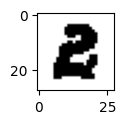

Label predito: 8 | Label real: 1


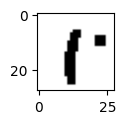

torch.Size([128, 1, 28, 28])
Label predito: 0 | Label real: 7


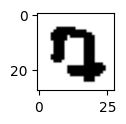

torch.Size([128, 1, 28, 28])
Label predito: 3 | Label real: 5


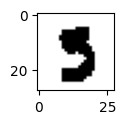

Label predito: 8 | Label real: 3


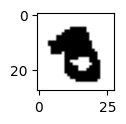

Label predito: 8 | Label real: 3


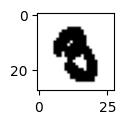

Label predito: 9 | Label real: 5


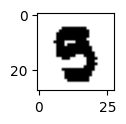

torch.Size([128, 1, 28, 28])
Label predito: 5 | Label real: 9


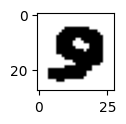

torch.Size([128, 1, 28, 28])
Label predito: 3 | Label real: 9


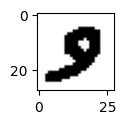

Label predito: 5 | Label real: 9


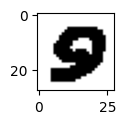

Label predito: 0 | Label real: 9


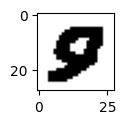

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
Label predito: 0 | Label real: 9


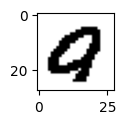

torch.Size([128, 1, 28, 28])
Label predito: 7 | Label real: 9


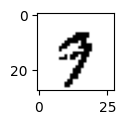

Label predito: 1 | Label real: 7


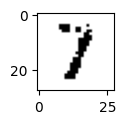

Label predito: 7 | Label real: 0


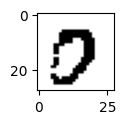

Label predito: 2 | Label real: 8


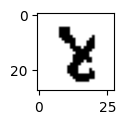

Label predito: 4 | Label real: 0


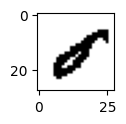

torch.Size([128, 1, 28, 28])
Label predito: 6 | Label real: 1


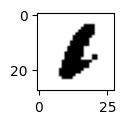

torch.Size([128, 1, 28, 28])
Label predito: 4 | Label real: 6


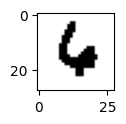

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
Label predito: 2 | Label real: 7


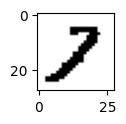

Label predito: 8 | Label real: 4


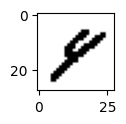

torch.Size([128, 1, 28, 28])
Label predito: 4 | Label real: 7


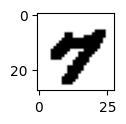

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
Label predito: 8 | Label real: 5


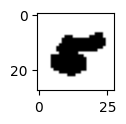

Label predito: 4 | Label real: 2


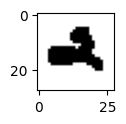

torch.Size([128, 1, 28, 28])
Label predito: 1 | Label real: 2


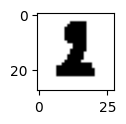

torch.Size([128, 1, 28, 28])
Label predito: 1 | Label real: 2


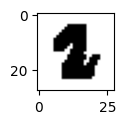

Label predito: 1 | Label real: 2


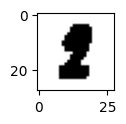

Label predito: 5 | Label real: 8


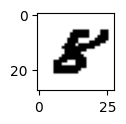

torch.Size([128, 1, 28, 28])
Label predito: 9 | Label real: 3


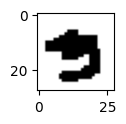

Label predito: 4 | Label real: 6


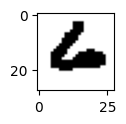

torch.Size([128, 1, 28, 28])
Label predito: 6 | Label real: 8


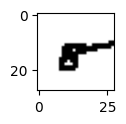

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
Label predito: 2 | Label real: 7


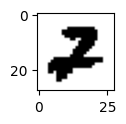

Label predito: 2 | Label real: 7


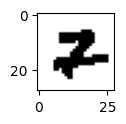

Label predito: 2 | Label real: 7


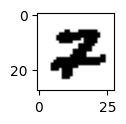

Label predito: 2 | Label real: 7


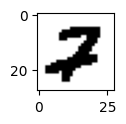

Label predito: 2 | Label real: 7


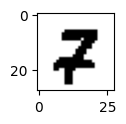

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
Label predito: 8 | Label real: 1


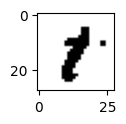

torch.Size([128, 1, 28, 28])
Label predito: 7 | Label real: 9


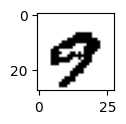

Label predito: 7 | Label real: 2


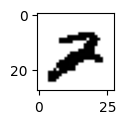

Label predito: 7 | Label real: 9


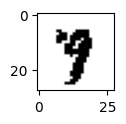

torch.Size([128, 1, 28, 28])
Label predito: 6 | Label real: 5


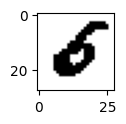

Label predito: 7 | Label real: 9


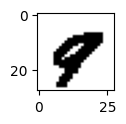

Label predito: 6 | Label real: 5


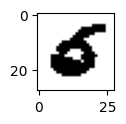

Label predito: 0 | Label real: 5


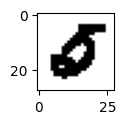

Label predito: 3 | Label real: 2


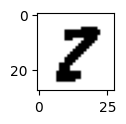

Label predito: 7 | Label real: 2


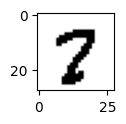

torch.Size([128, 1, 28, 28])
Label predito: 5 | Label real: 9


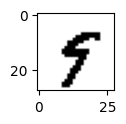

Label predito: 2 | Label real: 0


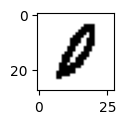

Label predito: 6 | Label real: 5


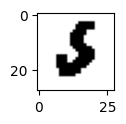

torch.Size([16, 1, 28, 28])


In [31]:

net.eval()

with torch.no_grad():

    for data in testloader:

        images, labels = data

        

        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)

        #Usamos argmax para pegar as predições em tensores muito longos
        predictions = torch.argmax(outputs, dim=1)

        # Para os dados de teste em cada lote, identificamos quando as previsões não corresponderam ao rótulo
        # então imprimimos a verdade real 
        print(data[0].shape)
        for i in range(data[0].shape[0]):
            pred = predictions[i].item()
            label = labels[i]
            if (label != pred):
                print(f"Label predito: {pred} | Label real: {label}")
                img = np.reshape(images[i].cpu().numpy(), [28,28])
                imgshow("", np.uint8(img), size=1)

## CALCULANDO A MATRIX DE CONFUSÃO

In [36]:
number_classes = 10

confusion_matrix = torch.zeros(number_classes, number_classes)

with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        # A função zip combina os elementos dos dois tensores (rótulos verdadeiros e previstos) par a par, criando um iterador de tuplas.
        # view(-1) transforma os tensores classes (rótulos verdadeiros) e preds (rótulos previstos) em vetores 1D (para garantir que sejam listas planas de elementos).
        for tru, pred in zip(classes.view(-1), preds.view(-1)):
            # .long() é para o formato dos dados serem int64
            # Se a predição for correta, coloca na diagonal principal + 1, se não, coloca +1 na posição errada, indicando erro.
            confusion_matrix[tru.long(), pred.long()] += 1


print(confusion_matrix)

tensor([[9.7300e+02, 0.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.1220e+03, 4.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         4.0000e+00, 1.0000e+00, 3.0000e+00, 0.0000e+00],
        [2.0000e+00, 4.0000e+00, 1.0120e+03, 3.0000e+00, 4.0000e+00, 0.0000e+00,
         1.0000e+00, 5.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 2.0000e+00, 9.9900e+02, 0.0000e+00, 5.0000e+00,
         0.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 3.0000e+00, 0.0000e+00, 9.7400e+02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 2.0000e+00, 3.0000e+00],
        [2.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00, 0.0000e+00, 8.7900e+02,
         3.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00],
        [6.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 4.0000e+00, 2.0000e+00,
         9.3800e+02, 0.0000e+00, 5.0000e+00, 0.0000e+00],
        [2.0000e+00, 5.0000

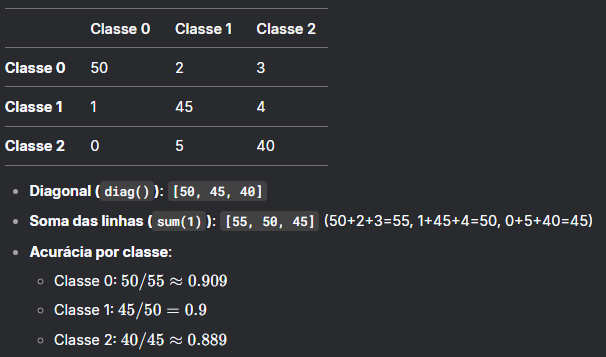

In [37]:
print(confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([0.9929, 0.9885, 0.9806, 0.9891, 0.9919, 0.9854, 0.9791, 0.9660, 0.9784,
        0.9604])


In [ ]:
from sklearn.metrics import confusion_matrix

nb_classes = 10

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()]) #concatena as predições no tensor de predições
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()]) # concatena as predições no tensor de classes


# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy()) #para usar o módulo do sklearn, temos que converter para numpy
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[[ 973    0    2    0    1    0    2    1    1    0]
 [   0 1122    4    1    0    0    4    1    3    0]
 [   2    4 1012    3    4    0    1    5    1    0]
 [   0    0    2  999    0    5    0    1    2    1]
 [   0    0    3    0  974    0    0    0    2    3]
 [   2    0    0    4    0  879    3    1    2    1]
 [   6    2    1    0    4    2  938    0    5    0]
 [   2    5   14    2    4    0    0  993    3    5]
 [   6    0    4    3    2    1    1    2  953    2]
 [   3    5    1    3   11    5    1   10    1  969]]
[99.28571429 98.85462555 98.0620155  98.91089109 99.18533605 98.5426009
 97.91231733 96.59533074 97.84394251 96.03567889]
